# Installation des librairies

In [1]:
import numpy as np 
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.display import display
from sklearn.feature_extraction.text import TfidfVectorizer
import nltk
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')
import re
import string
from nltk.tokenize import word_tokenize
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import warnings
warnings.simplefilter(action='ignore')
import nltk
from nltk.stem import WordNetLemmatizer
nltk.download('words')
import spacy
nlp = spacy.load("en_core_web_sm")
from scipy.cluster.hierarchy import linkage, fcluster
from scipy.spatial.distance import pdist

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\MS6283\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\MS6283\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\MS6283\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\MS6283\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package words to
[nltk_data]     C:\Users\MS6283\AppData\Roaming\nltk_data...
[nltk_data]   Package words is already up-to-date!


# Lecture des données

In [2]:
df0 = pd.read_csv("anthems.csv", encoding='utf-8')
print(df0.info())
df0.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 190 entries, 0 to 189
Data columns (total 5 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   Country    190 non-null    object
 1   Alpha-2    189 non-null    object
 2   Alpha-3    190 non-null    object
 3   Continent  190 non-null    object
 4   Anthem     190 non-null    object
dtypes: object(5)
memory usage: 7.5+ KB
None


,Country,Alpha-2,Alpha-3,Continent,Anthem
0,Albania,AL,ALB,Europe,"Around our flag we stand united, With one wish..."
1,Armenia,AM,ARM,Europe,"Our Fatherland, free, independent, That has fo..."
2,Austria,AT,AUT,Europe,"Land of mountains, land by the river, Land of ..."
3,Azerbaijan,AZ,AZE,Europe,"Azerbaijan, Azerbaijan! The glorious Fatherlan..."
4,Belarus,BY,BLR,Europe,"We, Belarusians, are peaceful people, Wholehea..."


Le fichier csv `anthems.csv` comporte une table de 190 lignes et 5 colonnes stockée en mémoire avec un poids de 7.5 KB. Il n'y a aucune valeur manquante et toutes les variables sont de type *string* ; ce sont toutes des variables qualitatives. 

**Dictionnaire de données :**
* **Country :** Nom complet du pays (*e.g.* Albania, France)
* **Alpha-2 :** Code ID du pays au format AA (*e.g.* Armenia pour AM, Belarus pour BY)
* **Alpha-3 :** Code ID du pays au format AAA (*e.g.* Armenia pour ARM, Belarus pour BLR)
* **Continent :** Nom complet du continent dans lequel se trouve le pays (*e.g.* France pour Europe, Canada pour Amérique)
* **Anthem :** Hymne nationale du pays 

# Création de la table de travail
Le stockage d'objet string est extrêmement coûteux en mémoire. Aussi, pour réaliser des analyses sur la variable `Anthem` uniquement nous décidons de créer deux tableaux. Le premier comportera les données de localisation et le second possédera la variable d'analyse. 

Lorsque nous réaliserons d'autres analyses, il sera utile de pouvoir récupérer les données de chaque tableau, il nous faut donc déterminer une clef ; pour cela nous avons besoin d'une variable comportant des données unique (*i.e.* sans doublon).

In [3]:
print("Nombre de doublon dans Alpha-2 :", df0["Alpha-2"].duplicated().sum())
print("")
print("Nombre de doublon dans Alpha-3 :", df0["Alpha-3"].duplicated().sum())

Nombre de doublon dans Alpha-2 : 1

Nombre de doublon dans Alpha-3 : 0


Au regard, de nos résultats, nous décidons de sélectionner la variable `Alpha-3`.

In [4]:
df1 = df0.drop(["Country", "Alpha-2", "Continent"], axis = 1)
tab_ref = df0.drop(["Anthem"], axis = 1)

In [5]:
print("Nom de colonnes de la table d'analyse : ", df1.columns)
print("Nom de colonnes de la table de référence : ", tab_ref.columns)

Nom de colonnes de la table d'analyse :  Index(['Alpha-3', 'Anthem'], dtype='object')
Nom de colonnes de la table de référence :  Index(['Country', 'Alpha-2', 'Alpha-3', 'Continent'], dtype='object')


# Nettoyage de la variable *Anthem*

In [6]:
stopwords = nltk.corpus.stopwords.words('english')
words = set(nltk.corpus.words.words())
lemmatizer = WordNetLemmatizer()

In [7]:
def clean_data_text(df, col_name):
    
    for row in range(len(df)):
        
        df.loc[row, col_name] = "".join([i.lower() for i in df.loc[row, col_name] if i not in string.punctuation]) #supprime la ponctuation et majuscule -> minuscule
        df.loc[row, col_name] = re.sub(r'[0-9]', '', df.loc[row, col_name]) #supprime les chiffres
        df.loc[row, col_name] = re.sub(r'\W|_', ' ', df.loc[row, col_name]) #supprime les caractères non alphanumérique et underscore
        df.loc[row, col_name] = re.sub(r'\s+', ' ', df.loc[row, col_name]) #supprime les doubles espaces
        df.loc[row, col_name] = re.sub(r'^\s|\s$', '', df.loc[row, col_name]) #supprime les espaces au début et fin du texte
        df.loc[row, col_name] = re.sub(r'\s+[a-zA-Z]\s+', ' ', df.loc[row, col_name]) #supprime les lettres isolées
        df.loc[row, col_name] = re.sub(r'^b\s+', ' ', df.loc[row, col_name]) #supprime les b isolés en début de ligne
        
        tokenize_phrase = nltk.tokenize.word_tokenize(df.loc[row, col_name]) #chaque caractère isolés par des espaces devient l'élément d'une liste
        df.loc[row, col_name] = [i for i in tokenize_phrase if i not in stopwords] #supprime les mots les plus courrants avec peu d'importance (ex:'our')

    return df 

In [8]:
df1 = clean_data_text(df1, "Anthem")
df1.head(3)

,Alpha-3,Anthem
0,ALB,"[around, flag, stand, united, one, wish, one, ..."
1,ARM,"[fatherland, free, independent, centuries, liv..."
2,AUT,"[land, mountains, land, river, land, fields, l..."


In [9]:
print('Phrase de base : ', df0['Anthem'][0])
print("")
print('Phrase nettoyée : ', df1["Anthem"][0])

Phrase de base :  Around our flag we stand united, With one wish and one goal, A sacred oath we bestow upon it Proclaiming loyalty for our salvation. From war abstains only he, Who a traitor is born, He who is a true man is not frightened, But dies a warrior to the cause. With weapons in our hands a-brandished, We will defend our fatherland, Our sacred rights weÃ¢â‚¬â„¢ll not relinquish, The foe has no place in our land. For God himself proclaimed The nations of the earth shall wane, And yet will live, will thrive Albania. For you, for you we fight. O Flag, flag, you sacred symbol Upon you we now swear For Albania, our dear fatherland For honour and your glory. Brave man is named and honoured The one who sacrificed himself for the fatherland Forever he will be remembered On earth and under as a saint!

Phrase nettoyée :  ['around', 'flag', 'stand', 'united', 'one', 'wish', 'one', 'goal', 'sacred', 'oath', 'bestow', 'upon', 'proclaiming', 'loyalty', 'salvation', 'war', 'abstains', 'trai

# Lemmatisation de la variable Anthem

In [14]:
def lemmatize_df(df, col_name):
    
    df1 = df.copy()
    df1[col_name] = df1[col_name].astype(str)
    df1[col_name] = df1[col_name].apply(lambda text: " ".join([token.lemma_ for token in nlp(text)]))
    
    return df1

In [15]:
df2 = df1.copy()
df2 = lemmatize_df(df2, "Anthem")

print("Types associés aux mots de la première hymne :")
print("")
print(df2["Anthem"][0])

Types associés aux mots de la première hymne :

[ ' around ' , ' flag ' , ' stand ' , ' united ' , ' one ' , ' wish ' , ' one ' , ' goal ' , ' sacred ' , ' oath ' , ' bestow ' , ' upon ' , ' proclaim ' , ' loyalty ' , ' salvation ' , ' war ' , ' abstain ' , ' traitor ' , ' bear ' , ' true ' , ' man ' , ' frightened ' , ' die ' , ' warrior ' , 'cause ' , ' weapon ' , ' hand ' , ' abrandishe ' , ' defend ' , ' fatherland ' , ' sacred ' , ' right ' , ' weã ' , ' â ' , ' â ' , ' relinquish ' , ' foe ' , ' place ' , ' land ' , ' god ' , ' proclaim ' , ' nation ' , ' earth ' , ' shall ' , ' wane ' , ' yet ' , ' live ' , ' thrive ' , ' albania ' , ' fight ' , ' flag ' , ' flag ' , ' sacred ' , ' symbol ' , ' upon ' , ' swear ' , ' albania ' , ' dear ' , ' fatherland ' , ' honour ' , ' glory ' , ' brave ' , ' man ' , ' name ' , ' honour ' , ' one ' , ' sacrifice ' , ' fatherland ' , ' forever ' , ' remember ' , ' earth ' , ' saint ' ]


# Grammaire de la variable Anthem

In [16]:
def type_mot(phrase):
    
    type_list = []
    
    for mot in phrase:
        doc = nlp(mot)
        type_list.append([(token, token.pos_) for token in doc])
    
    return type_list

df2_type = df2.copy()
df2_type = df2_type["Anthem"].apply(lambda x: type_mot(x))

print("Types associés aux mots de la première hymne :")
print("")
print(df2_type[0])

In [17]:
df2_type = df2.copy()
df2_type = df2_type["Anthem"].apply(lambda x: type_mot(x))

print("Types associés aux mots de la première hymne :")
print("")
print(df2_type[0])

Types associés aux mots de la première hymne :

[[([, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(a, 'PRON')], [(r, 'X')], [(o, 'X')], [(u, 'NOUN')], [(n, 'CCONJ')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(f, 'X')], [(l, 'NOUN')], [(a, 'PRON')], [(g, 'PROPN')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(s, 'NOUN')], [(t, 'NOUN')], [(a, 'PRON')], [(n, 'CCONJ')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(u, 'NOUN')], [(n, 'CCONJ')], [(i, 'PRON')], [(t, 'NOUN')], [(e, 'X')], [(d, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(o, 'X')], [(n, 'CCONJ')], [(e, 'X')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPACE')], [(,, 'PUNCT')], [( , 'SPACE')], [(', 'PUNCT')], [( , 'SPA

# Vectorisation de la variable

In [35]:
def text_vectorization(data, col, size):
    tfidf_vect = TfidfVectorizer(analyzer='word', max_features=size)
    
    X = tfidf_vect.fit_transform(data[col].apply(lambda x: ' '.join(eval(x))))
    
    data_text = pd.DataFrame(X.toarray(), columns=tfidf_vect.get_feature_names())
    data = pd.concat([data, data_text], axis=1)
    data.drop([col], axis=1, inplace=True)
    
    return data

In [36]:
df3= df2.copy()
df3= text_vectorization(df3, "Anthem", size=600)
df3.head()

,Alpha-3,achieve,across,adore,adorn,advance,africa,age,ah,air,...,would,write,year,yes,yet,yoke,you,young,zambia,zealand
0,ALB,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.126498,0.0,0.0,0.000000,0.0,0.0
1,ARM,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,AUT,0.0,0.0,0.0,0.0,0.0,0.0,0.198674,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,AZE,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.073966,0.0,0.0
4,BLR,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


# Identification du nombre optimal de mots à étudier

## PCA et Kaiser : *identifie les variables les plus importantes ou celles expliquant 95% de la variance*

In [37]:
def optimal_dimensions(df, drop_column):
    X = df.drop([drop_column], axis=1)
    pca = PCA()
    X_pca = pca.fit_transform(X)
    explained_variance = np.cumsum(pca.explained_variance_ratio_)
    n_components = np.argmax(explained_variance >= 0.95) + 1
    
    n_components_kaiser = np.sum(pca.explained_variance_ > 1.0/len(X.columns))

    return n_components, n_components_kaiser

In [38]:
n_components, n_components_kaiser = optimal_dimensions(df3, 'Alpha-3')
print("Nombre optimal de dimensions (PCA) :", n_components)
print("Nombre optimal de dimensions (Kaiser) :", n_components_kaiser)

Nombre optimal de dimensions (PCA) : 153
Nombre optimal de dimensions (Kaiser) : 160


## Re-Vectorisation avec le nombre optimal de dimension pour réduire les données

In [43]:
df4= df2.copy()
df4= text_vectorization(df4, "Anthem", size=153)
df4.head()

,Alpha-3,africa,always,ancestor,arise,arm,banner,battle,bear,beautiful,...,voice,vow,war,warrior,wave,we,well,work,world,year
0,ALB,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.134555,0.000000,...,0.0,0.0,0.132391,0.150783,0.000000,0.000000,0.0,0.0,0.0,0.0
1,ARM,0.0,0.0,0.000000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.117449,0.0,0.0,0.0,0.0
2,AUT,0.0,0.0,0.184601,0.0,0.0,0.000000,0.000000,0.193472,0.176917,...,0.0,0.0,0.000000,0.000000,0.000000,0.179658,0.0,0.0,0.0,0.0
3,AZE,0.0,0.0,0.000000,0.0,0.0,0.203387,0.100117,0.000000,0.000000,...,0.0,0.0,0.000000,0.115821,0.097186,0.047988,0.0,0.0,0.0,0.0
4,BLR,0.0,0.0,0.000000,0.0,0.0,0.248192,0.244344,0.000000,0.000000,...,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0


# Clustering de la variable Anthem

## Création des clusters

In [44]:
def get_silhouette_scores(data, max_k):
    scores = []
    
    for k in range(2, max_k+1):
        kmeans = KMeans(n_clusters=k, random_state=0).fit(data)
        score = silhouette_score(data, kmeans.labels_)
        scores.append(score)
    
    return scores

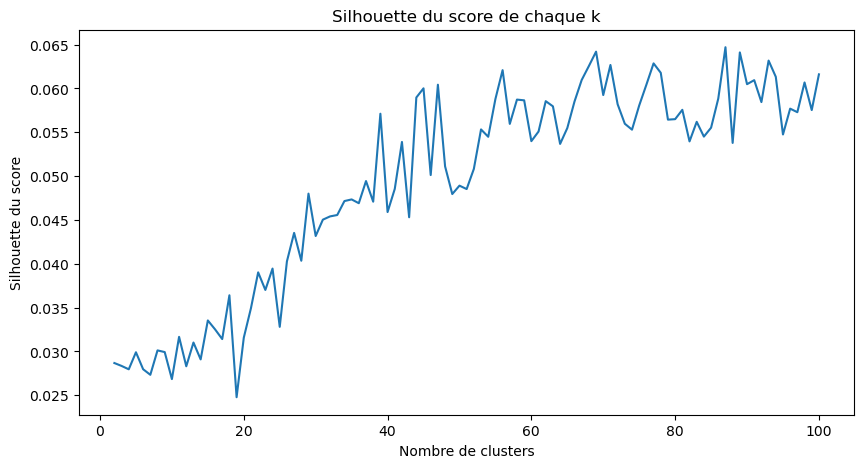

In [49]:
max_k = 100

df4_num = df4.drop("Alpha-3", axis= 1)

df4_array = df4_num.values
scores = get_silhouette_scores(df4_array, max_k)

plt.figure(figsize=(10,5))

plt.plot(range(2, max_k+1), scores)

plt.title("Silhouette du score de chaque k")
plt.xlabel("Nombre de clusters")
plt.ylabel("Silhouette du score")

plt.show()

In [51]:
n_clusters = np.argmax(scores) + 2  # Nombre optimal de clusters
kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(df4_array)
labels = kmeans.labels_

print("Nombre optimal de clusters: ", n_clusters)
print("Labels des clusters: ", labels)

Nombre optimal de clusters:  87
Labels des clusters:  [53 23 32 12 79 30 74 58 65 31 14 62 18  2  7 39 86 31 55 33 83 23 63 18
 42 46 81 13 61 17 67  8  7 83 34 18 12 51 11 35 53 69 46 26 15 23  1 27
 36 15  2 25 42 71 34 25 14 64 18 27 15  0 23  3 38 12 62 85 78 67 44 54
  3 73 10 45  4  4 10 59  0 57 57  4 10  8 28 50 52 69 13 35 75 29 26  6
 22 12 32 47 19 33 33 35 70 42 38 25 70 22 29 24 70 41 41  0  8  9 40 12
 49 35  6 32 24 60 35 77 11 20  5 20 84 11 66 25 37  8 25 44 12 51 48 37
 10  6 28 19 82 56 50  0 38 45 16 19 12 45  9 31 80 18  2 16 43  4 44  7
 72  6 45  6  0 10 25 16 21  4 68 43 68 27 17 63  6 76  8 85 39  9]


## Identification des mots significatifs dans chaque cluster

In [54]:
df4['Cluster'] = labels

for i in range(n_clusters):
    print(f"\nCluster {i}:")
    cluster_hymne = df4[df4['Cluster']==i]

    cluster_words = df4.loc[df4['Cluster']==i].drop(columns=['Alpha-3', 'Cluster']).sum().sort_values(ascending=False)
    print(f"\nMots les plus fréquents par cluster {i}:")
    print(cluster_words[:10])


Cluster 0:

Mots les plus fréquents par cluster 0:
we           2.086764
let          1.947281
ancestor     0.721449
sing         0.571060
country      0.552980
may          0.549244
forever      0.534023
hand         0.465060
rise         0.442356
beautiful    0.438204
dtype: float64

Cluster 1:

Mots les plus fréquents par cluster 1:
thou        0.536121
homeland    0.372387
beloved     0.367684
thy         0.277730
hail        0.263750
strong      0.176798
love        0.170744
sky         0.168537
son         0.154808
thousand    0.136309
dtype: float64

Cluster 2:

Mots les plus fréquents par cluster 2:
land      1.261193
free      0.868905
one       0.585506
dear      0.571489
mother    0.398785
we        0.355475
build     0.297752
see       0.288890
time      0.285712
soil      0.285016
dtype: float64

Cluster 3:

Mots les plus fréquents par cluster 3:
blue        0.635075
sea         0.569219
star        0.490772
tyrant      0.389086
keep        0.388826
free        0.330979
l


Mots les plus fréquents par cluster 77:
blood           0.478402
independence    0.322150
war             0.311670
never           0.297857
every           0.275134
forever         0.268634
united          0.265544
die             0.254109
long            0.232547
freedom         0.209825
dtype: float64

Cluster 78:

Mots les plus fréquents par cluster 78:
sea       0.623669
sun       0.616782
oh        0.366060
bear      0.150489
land      0.147459
wave      0.141506
sing      0.127623
sky       0.126155
man       0.000000
people    0.000000
dtype: float64

Cluster 79:

Mots les plus fréquents par cluster 79:
motherland    0.378373
people        0.373206
glory         0.339637
live          0.256831
banner        0.248192
battle        0.244344
beloved       0.230664
victory       0.227601
name          0.206770
bless         0.204530
dtype: float64

Cluster 80:

Mots les plus fréquents par cluster 80:
god        0.644096
great      0.422571
tyrant     0.289599
truth      0.279797
si

# Diminution des dimensions pour visualiser les clusters

In [62]:
features = df4.drop(columns=['Alpha-3', 'Cluster']).values

In [63]:
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

clusters = df4['Cluster'].values

df_visualize = pd.DataFrame(data=features_pca, columns=['PC1', 'PC2'])
df_visualize['Cluster'] = clusters

In [64]:
num_clusters = len(df_visualize['Cluster'].unique())

colors = cm.get_cmap('tab10', num_clusters)

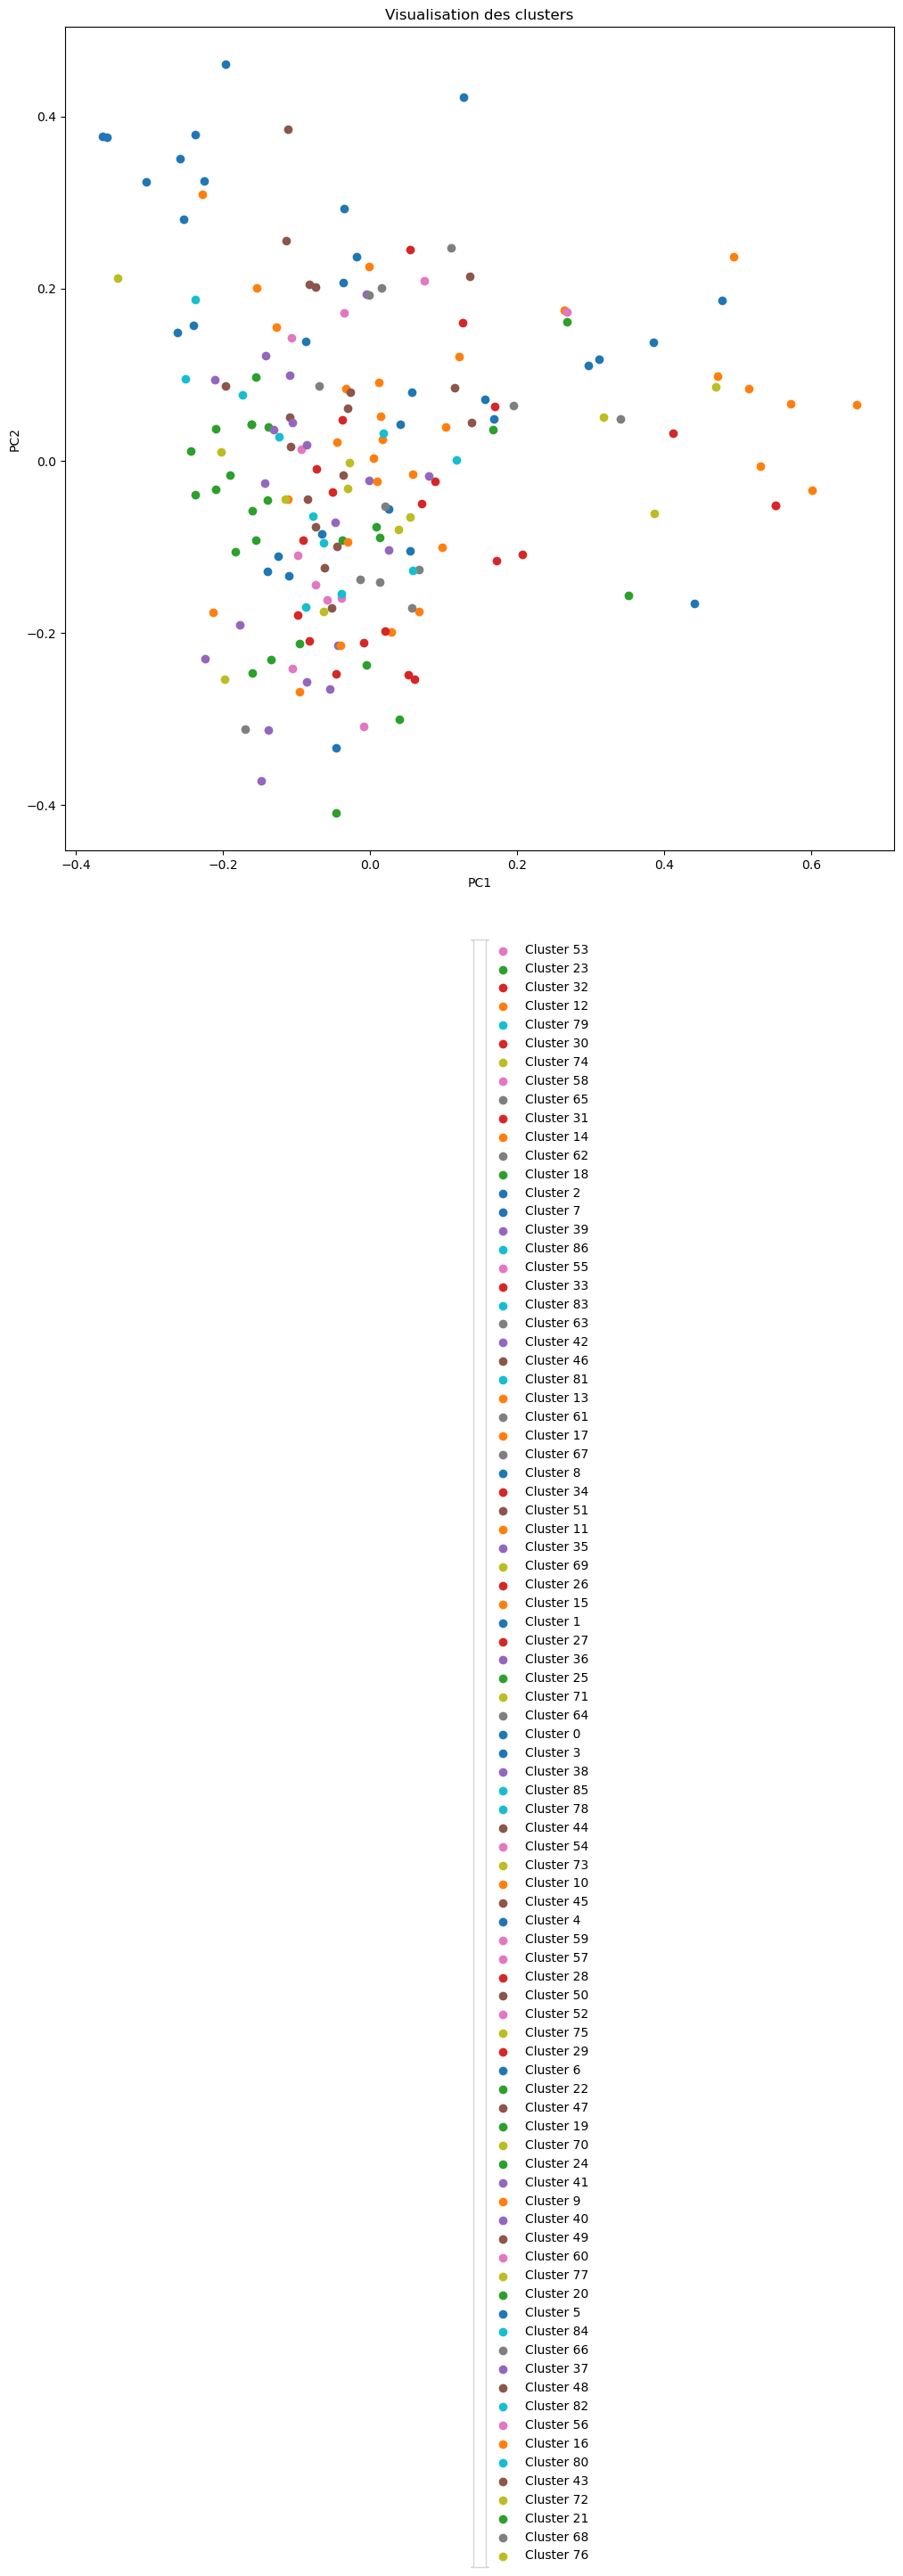

In [67]:
plt.figure(figsize=(12, 12))

for cluster in df_visualize['Cluster'].unique():
    df_cluster = df_visualize[df_visualize['Cluster'] == cluster]
    plt.scatter(df_cluster['PC1'], df_cluster['PC2'], color=colors(cluster), label=f'Cluster {cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Visualisation des clusters')
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, mode='expand')

plt.show()

In [74]:
distance_matrix = pdist(df_visualize[['PC1', 'PC2']], metric='euclidean') #Matrice des distances de type euclidienne

In [75]:
linkage_matrix = linkage(distance_matrix, method='average') #Regroupement hiérarchique
clusters = fcluster(linkage_matrix, t=10, criterion='maxclust') #définition du nombre de cluster dans chaque regroupement

In [76]:
df_visualize['Merged_Cluster'] = clusters
color_map = plt.get_cmap('tab10')
merged_cluster_labels = df_visualize['Merged_Cluster'].unique()

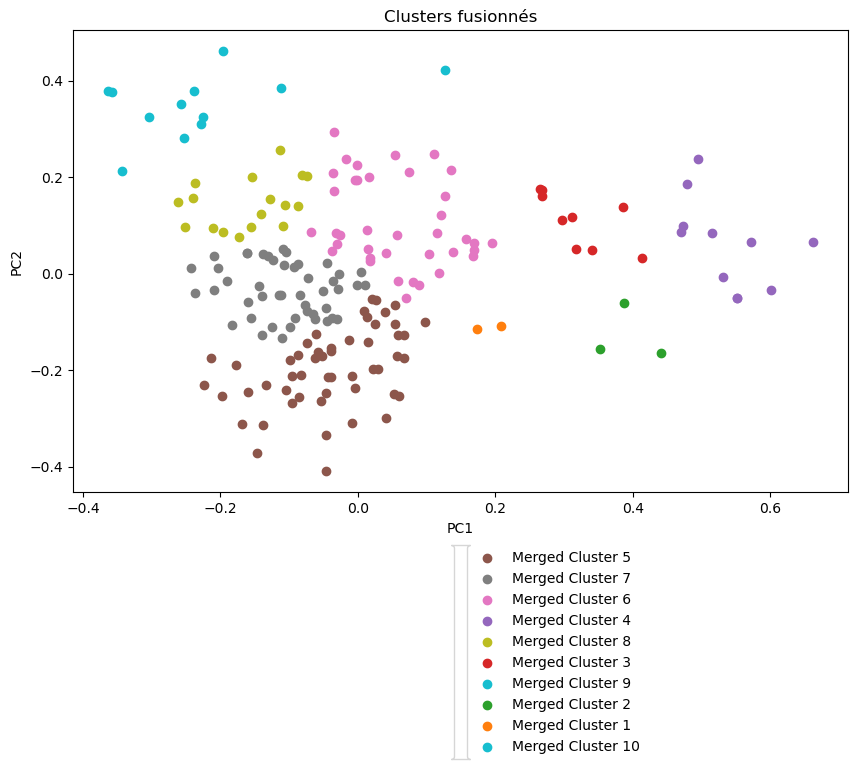

In [77]:
plt.figure(figsize=(10,6))

for merged_cluster in merged_cluster_labels:
    df_merged_cluster = df_visualize[df_visualize['Merged_Cluster'] == merged_cluster]
    plt.scatter(df_merged_cluster['PC1'], df_merged_cluster['PC2'], color=color_map(merged_cluster), label=f'Merged Cluster {merged_cluster}')

plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('Clusters fusionnés')

plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=1, mode='expand')

plt.show()